# Import

In [1]:
import torch
from transformers import GPT2LMHeadModel, GPT2Tokenizer, TrainingArguments, Trainer, DataCollatorForLanguageModeling
from datasets import load_dataset, DatasetDict, Dataset
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# Dataset

In [2]:
dataset = load_dataset("shuttie/dadjokes")

In [3]:
dataset

DatasetDict({
    train: Dataset({
        features: ['question', 'response'],
        num_rows: 52000
    })
    test: Dataset({
        features: ['question', 'response'],
        num_rows: 1400
    })
})

In [4]:
train_data = dataset["train"]
test_data = dataset["test"]

# Fusionnez les colonnes "question" et "response" en une nouvelle colonne "text" en vérifiant les valeurs nulles
train_data = [f"{item['question'] + '. ' if item['question'] else ''}{item['response']}" for item in train_data]
test_data = [f"{item['question'] + '. ' if item['question'] else ''}{item['response']}" for item in test_data]


In [5]:
train_subset = Dataset.from_dict({"text": train_data + test_data})

# Créez un DatasetDict contenant le sous-ensemble "train"
dataset = DatasetDict({"train": train_subset})

In [6]:
dataset

DatasetDict({
    train: Dataset({
        features: ['text'],
        num_rows: 53400
    })
})

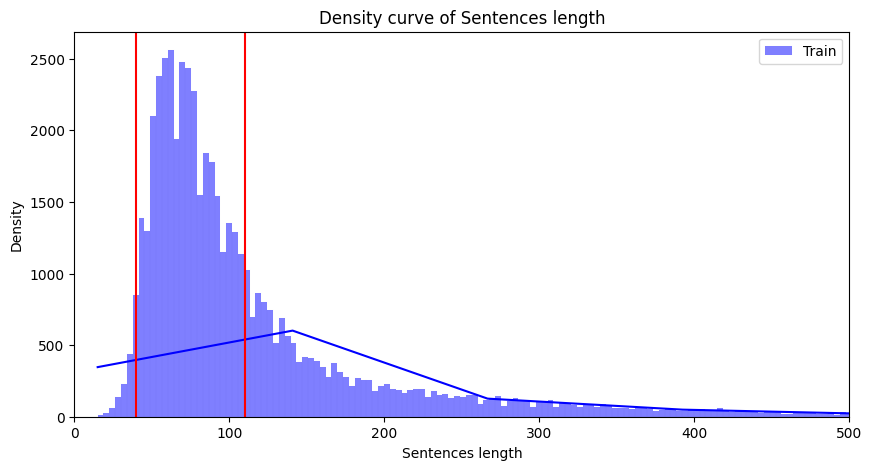

In [7]:
lengths_dataset_elements = [len(example['text']) for example in dataset['train']]

# Créer un histogramme et une courbe de densité
plt.figure(figsize=(10,5))
sns.histplot(lengths_dataset_elements, kde=True, label='Train', color='blue')

plt.title("Density curve of Sentences length")
plt.xlabel("Sentences length")
plt.ylabel("Density")
plt.xlim(0, 500)
plt.axvline(40,color="red")
plt.axvline(110,color="red")
plt.legend()
plt.show()

In [8]:
min_length = 40
max_length = 110

train_filtered = dataset.filter(lambda example: min_length <= len(example['text']) <= max_length)

Filter:   0%|          | 0/53400 [00:00<?, ? examples/s]

In [9]:
train_filtered["train"]

Dataset({
    features: ['text'],
    num_rows: 33758
})

In [10]:
splits_train_temp = train_filtered['train'].train_test_split(test_size=0.25, seed=42)

splits_val_test = splits_train_temp['test'].train_test_split(test_size=0.4, seed=42)

dataset_dict = DatasetDict({
    'train': splits_train_temp['train'],
    'val': splits_val_test['train'],
    'test': splits_val_test['test']
})

In [11]:
dataset_dict

DatasetDict({
    train: Dataset({
        features: ['text'],
        num_rows: 25318
    })
    val: Dataset({
        features: ['text'],
        num_rows: 5064
    })
    test: Dataset({
        features: ['text'],
        num_rows: 3376
    })
})

# Tokenizer & Tokenization

In [12]:
# Tokenizer

tokenizer = GPT2Tokenizer.from_pretrained("gpt2")

tokenizer.pad_token = tokenizer.eos_token


In [13]:
# Tokenization 1

tokenized_dataset = dataset_dict.map(lambda examples: tokenizer(examples["text"], padding=True, max_length=max_length,truncation=True),batched=True)

Map:   0%|          | 0/25318 [00:00<?, ? examples/s]

Map:   0%|          | 0/5064 [00:00<?, ? examples/s]

Map:   0%|          | 0/3376 [00:00<?, ? examples/s]

# Model + params + trainer 

In [14]:
model = GPT2LMHeadModel.from_pretrained("gpt2")

In [15]:
data_collator = DataCollatorForLanguageModeling(
    tokenizer=tokenizer,
    mlm=False
)

In [16]:
training_args = TrainingArguments(
    per_device_train_batch_size=16,
    per_device_eval_batch_size=8,
    num_train_epochs=3,
    learning_rate=0.0001,
    evaluation_strategy="steps",
    eval_steps=500,
    save_steps=500,
    output_dir="./quotes_model",
    overwrite_output_dir=True,
    save_total_limit=2
)

In [17]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset["val"],
    data_collator=data_collator,
)

trainer.train()


Step,Training Loss,Validation Loss
500,0.872900,1.325165
1000,0.788700,1.271895
1500,0.767800,1.235400
2000,0.660700,1.229238
2500,0.674200,1.212048
3000,0.661100,1.198607
3500,0.610600,1.209909
4000,0.601800,1.204408
4500,0.588900,1.203201


TrainOutput(global_step=4749, training_loss=0.6868821138280345, metrics={'train_runtime': 18653.1035, 'train_samples_per_second': 4.072, 'train_steps_per_second': 0.255, 'total_flos': 3229755277824000.0, 'train_loss': 0.6868821138280345, 'epoch': 3.0})

In [34]:
tokenizer.save_pretrained("tokenizer")

('tokenizer/tokenizer_config.json',
 'tokenizer/special_tokens_map.json',
 'tokenizer/vocab.json',
 'tokenizer/merges.txt',
 'tokenizer/added_tokens.json')

In [35]:
model.save_pretrained("model")

In [20]:
results = trainer.evaluate(tokenized_dataset["test"])

In [21]:
results

{'eval_loss': 1.289910078048706,
 'eval_runtime': 90.1078,
 'eval_samples_per_second': 37.466,
 'eval_steps_per_second': 4.683,
 'epoch': 3.0}

# Generation 

In [2]:
model = GPT2LMHeadModel.from_pretrained("model")
tokenizer = GPT2Tokenizer.from_pretrained("tokenizer")

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [3]:
def exploit_best_token_while_exploring(probabilities, exploration_len=5):
    probabilities = probabilities.cpu().numpy()
    top_indices = np.argpartition(probabilities, -exploration_len)[-exploration_len:]
    top_probabilities = probabilities[top_indices]
    top_probabilities = top_probabilities / np.sum(top_probabilities)
    choice = np.random.choice(exploration_len, 1, p=top_probabilities)
    next_token_id = int(top_indices[choice][0])
    return next_token_id

In [34]:
def generate_joke(model, tokenizer, joke_length=50):
    current_joke = tokenizer.encode(" ", return_tensors="pt")
    
    device = torch.device("cpu")
    model.to(device)
    current_joke = current_joke.to(device)

    for pos in range(joke_length):
        with torch.no_grad():
            output = model(current_joke)
            logits = output[0]
            softmax_logits = torch.nn.functional.softmax(logits[0, -1], dim=0)
            if pos==0:
                exploration_len = 50

            token_to_append = exploit_best_token_while_exploring(softmax_logits, exploration_len)
            current_joke = torch.cat([current_joke, torch.tensor([[token_to_append]], dtype=torch.long).to(device)], dim=1)
            results = current_joke[0]
            if token_to_append in tokenizer.encode(" ",return_tensors="pt"):
                return tokenizer.decode(list(torch.squeeze(current_joke)))

    return tokenizer.decode(results)

In [49]:
generated_joke = generate_joke(model, tokenizer)
generated_joke

' A man got arrested for battery. He got caught on battery charges. Because he didn’t charge his cellphones… oh wait. It was an ON battery charge… [It was on battery] :) [He took battery off charge](https'

In [60]:
generated_joke = generate_joke(model, tokenizer)
generated_joke

' �Son, don’t be sad. You’re depressed,. That’s the point of this joke. :) '

In [111]:
generated_joke = generate_joke(model, tokenizer)
generated_joke

' How do dogs see a parrot. With their binoculars '

In [161]:
generated_joke = generate_joke(model, tokenizer)
generated_joke

' �sorry if this pun isn’t funny. I just made up all my words. ” '

In [168]:
generated_joke = generate_joke(model, tokenizer)
generated_joke

" My brother has a phobia of stairs. He's always up to something "